# Importaciones de librerías

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scikitplot.cluster import plot_elbow_curve
from scikitplot.metrics import plot_silhouette
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from src.modeling.utils.utils import drop_dataset_unnecessary_columns
from src.modeling.utils.utils import pca
from src.modeling.utils.utils import print_scores
from src.preparation.data_access.obtained_text_da import ObtainedTextDA
from typing import List
%matplotlib inline

/home/hans/Documentos/Tesis_Chatbot/env/lib/python3.8/site-packages/sqlalchemy/orm/util.py:104: SAWarning: The 'delete-orphan' cascade option requires 'delete'.
  util.warn(


# Constantes

# Funciones extra

In [2]:
def plot_multiple_silhouette(data, clusters: int=1, **args):
    '''
    This function plots the silhouette plot for different amount of clusters.
    '''
    for i in range(2, clusters+1):
        clf = KMeans(n_clusters=i, **args)
        clf.fit(data)
        cluster_labels = clf.predict(data)
        plot_silhouette(data, cluster_labels)
        plt.show()

In [3]:
def do_clustering(dataset, dataset_two_dim, clusters=2, target='grade', x='X', y='Y'):
    '''
    This function does the clustering 
    '''
    clf = KMeans(n_clusters=clusters, random_state=43)
    clf.fit(dataset)
    cluster_labels = pd.DataFrame(clf.predict(dataset), columns=[target])
    sns.scatterplot(data=pd.concat([dataset_two_dim, cluster_labels], axis=1), x=x, y=y, hue=target)
    plt.show()
    return cluster_labels

# Obteniendo los datos

Aquí, se obtienen las características halladas por la herramienta que calcula métricas de complejidad textual para todos los textos. Los textos serán agrupados, más adelante en el presente reporte, mediante dichas métricas halladas, las cuales son 48 en total.

In [4]:
ot_da = ObtainedTextDA()
texts = ot_da.select_all_as_dataframe().drop(columns=['cluster_grade'])
columns = [c for c in texts.columns if c not in ['category', 'filename', 'grade', 'id']]
texts.head()

,CNCADC,CNCAdd,CNCAll,CNCCaus,CNCLogic,CNCTemp,CRFANP1,CRFANPa,CRFAO1,CRFAOa,...,WRDPRP1s,WRDPRP2p,WRDPRP2s,WRDPRP3p,WRDPRP3s,WRDVERB,category,filename,grade,id
0,5.595524,0.532907,56.754596,17.319478,30.109246,3.197442,0.099526,0.079630,0.236967,0.148887,...,0.000000,0.0,0.000000,2.398082,10.125233,110.578204,"Historia, Geografía y Economía",atahualpa.txt,1.0,1.0
1,4.526167,0.848656,56.294201,13.861386,33.663366,3.394625,0.159722,0.119540,0.291667,0.197797,...,0.565771,0.0,0.848656,2.545969,8.769448,94.766620,"Historia, Geografía y Economía",avelino_caceres.txt,1.0,2.0
2,1.737619,0.000000,59.079062,11.294526,40.834057,5.212858,0.026316,0.019822,0.197368,0.150034,...,0.000000,0.0,5.212858,1.737619,9.556907,149.435274,"Historia, Geografía y Economía",cartilla_fenomeno_nino.txt,1.0,3.0
3,1.765225,1.765225,64.430715,12.356575,44.130627,4.413063,0.035714,0.039216,0.166667,0.142577,...,0.000000,0.0,9.708738,0.000000,9.708738,151.809356,"Historia, Geografía y Economía",cartilla_inundaciones.txt,1.0,4.0
4,5.965697,0.248571,52.945563,13.422819,30.325628,2.982849,0.151515,0.171011,0.430303,0.273384,...,0.000000,0.0,0.000000,1.739995,10.688541,93.711161,"Historia, Geografía y Economía",enrique_meiggs.txt,1.0,5.0


# Clustering con todos los datos

En esta sección del reporte se realizará Clustering, usando el algoritmo KMeans, con todos los documentos obetnidos y almacenados en la base de datos. Esto significa que no se diferenciaran textos de Ciencia y Tecnología, Comunicación ni Historia, Geografía y Economía.

## Dividiendo el dataset

 En esta subsección, se obtendrán las columnas numéricas necesarias para realizar la experimentación, obviando columnas categóricas como el nombre del archivo, la categoría (CTA, Historia, Geografía y economía, y Comunicación) y el ID.

In [5]:
X = texts[columns + ['grade']].dropna().copy()
X

,CNCADC,CNCAdd,CNCAll,CNCCaus,CNCLogic,CNCTemp,CRFANP1,CRFANPa,CRFAO1,CRFAOa,...,WRDNOUN,WRDPRO,WRDPRP1p,WRDPRP1s,WRDPRP2p,WRDPRP2s,WRDPRP3p,WRDPRP3s,WRDVERB,grade
0,5.595524,0.532907,56.754596,17.319478,30.109246,3.197442,0.099526,0.079630,0.236967,0.148887,...,338.395950,38.635758,0.000000,0.000000,0.000000,0.000000,2.398082,10.125233,110.578204,1.0
1,4.526167,0.848656,56.294201,13.861386,33.663366,3.394625,0.159722,0.119540,0.291667,0.197797,...,305.516266,38.189533,0.848656,0.565771,0.000000,0.848656,2.545969,8.769448,94.766620,1.0
2,1.737619,0.000000,59.079062,11.294526,40.834057,5.212858,0.026316,0.019822,0.197368,0.150034,...,278.019114,32.145960,0.000000,0.000000,0.000000,5.212858,1.737619,9.556907,149.435274,1.0
3,1.765225,1.765225,64.430715,12.356575,44.130627,4.413063,0.035714,0.039216,0.166667,0.142577,...,265.666372,52.956752,0.000000,0.000000,0.000000,9.708738,0.000000,9.708738,151.809356,1.0
4,5.965697,0.248571,52.945563,13.422819,30.325628,2.982849,0.151515,0.171011,0.430303,0.273384,...,325.130500,38.528461,0.000000,0.000000,0.000000,0.000000,1.739995,10.688541,93.711161,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,10.168675,1.012048,60.096386,15.084337,24.626506,9.204819,0.153777,0.113482,0.229317,0.130330,...,214.987952,88.867470,4.048193,12.144578,2.650602,15.180723,2.409639,20.192771,118.265060,2.0
179,8.489796,0.593692,56.653061,15.762523,25.751391,6.055659,0.072211,0.051115,0.170490,0.105130,...,233.202226,51.799629,4.779221,10.241187,0.044527,2.077922,1.128015,9.261596,108.897959,2.0
180,8.669041,0.941620,74.623352,19.456726,40.274707,5.281258,0.328918,0.254774,0.546726,0.382347,...,210.595267,62.586997,1.565954,20.848686,0.194465,0.020470,3.531073,13.745599,114.120200,2.0
181,4.147928,0.218312,82.958564,22.355150,52.045584,4.191591,0.287313,0.192939,0.375622,0.225790,...,301.619875,87.630441,1.309872,22.879099,0.480286,2.357770,2.969043,22.922761,102.606645,2.0


## PCA

Luego, para visualizar el conjunto de datos, se hara una reducción de dimensionalidad, a dos dimensiones, mediante el análisis de componentes principales (PCA), usando los datos numéricos pero estando estos estandarizados mediante la clase StandardScaler de Scikit learn.

In [6]:
X[['pca1', 'pca2']] = pca(StandardScaler().fit_transform(X[columns]), 2)
X

,CNCADC,CNCAdd,CNCAll,CNCCaus,CNCLogic,CNCTemp,CRFANP1,CRFANPa,CRFAO1,CRFAOa,...,WRDPRP1p,WRDPRP1s,WRDPRP2p,WRDPRP2s,WRDPRP3p,WRDPRP3s,WRDVERB,grade,pca1,pca2
0,5.595524,0.532907,56.754596,17.319478,30.109246,3.197442,0.099526,0.079630,0.236967,0.148887,...,0.000000,0.000000,0.000000,0.000000,2.398082,10.125233,110.578204,1.0,-1.284520,2.207961
1,4.526167,0.848656,56.294201,13.861386,33.663366,3.394625,0.159722,0.119540,0.291667,0.197797,...,0.848656,0.565771,0.000000,0.848656,2.545969,8.769448,94.766620,1.0,-1.027414,3.392499
2,1.737619,0.000000,59.079062,11.294526,40.834057,5.212858,0.026316,0.019822,0.197368,0.150034,...,0.000000,0.000000,0.000000,5.212858,1.737619,9.556907,149.435274,1.0,0.856956,0.131549
3,1.765225,1.765225,64.430715,12.356575,44.130627,4.413063,0.035714,0.039216,0.166667,0.142577,...,0.000000,0.000000,0.000000,9.708738,0.000000,9.708738,151.809356,1.0,2.677375,-0.210002
4,5.965697,0.248571,52.945563,13.422819,30.325628,2.982849,0.151515,0.171011,0.430303,0.273384,...,0.000000,0.000000,0.000000,0.000000,1.739995,10.688541,93.711161,1.0,-2.244327,3.082510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,10.168675,1.012048,60.096386,15.084337,24.626506,9.204819,0.153777,0.113482,0.229317,0.130330,...,4.048193,12.144578,2.650602,15.180723,2.409639,20.192771,118.265060,2.0,7.189265,1.071768
179,8.489796,0.593692,56.653061,15.762523,25.751391,6.055659,0.072211,0.051115,0.170490,0.105130,...,4.779221,10.241187,0.044527,2.077922,1.128015,9.261596,108.897959,2.0,4.423286,0.510999
180,8.669041,0.941620,74.623352,19.456726,40.274707,5.281258,0.328918,0.254774,0.546726,0.382347,...,1.565954,20.848686,0.194465,0.020470,3.531073,13.745599,114.120200,2.0,5.536650,7.454229
181,4.147928,0.218312,82.958564,22.355150,52.045584,4.191591,0.287313,0.192939,0.375622,0.225790,...,1.309872,22.879099,0.480286,2.357770,2.969043,22.922761,102.606645,2.0,5.750145,4.521417


## Gráfico de dispersion con las clases originales

En esta sección se visualizarán los datos usando los componentes principales hallados mediante PCA para visualizar el conjunto de datos, agrupados por el grado (1=Primaria, 2=Secundaria). Debido a la reducción de dimensionalidad, se pierde la información contenida en los demás atributos del conjunto de datos. Ello ocasiona que la visualización no necesariamente representa la distribución real del conjunto de datos. Sin embargo, se demostrará, mediante Clustering, que existe divisibilidad en el conjunto de datos.

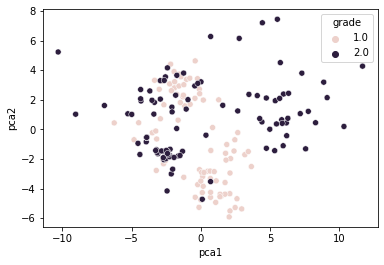

In [7]:
sns.scatterplot(data=X, x='pca1', y='pca2', hue='grade')
plt.show()

## Realizando clustering

### Gráfico de Inercia por número de clases (Gráfico de Codo)

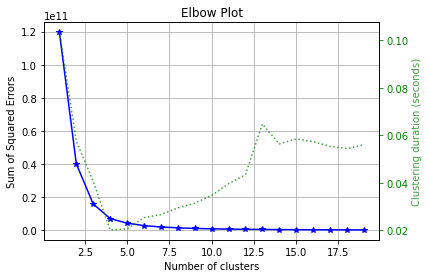

In [8]:
plot_elbow_curve(clf=KMeans(random_state=43, tol=1), X=X[columns], cluster_ranges=range(1, 20))
plt.show()

En el anterior gráfico se observa la cantidad de clusters, o clases, adecuados para el presente conjunto de datos. La coordenada donde se puede ver una curvatura de similar a un "codo" es la cual indica la cantidad adecuada de clases. En este caso, luego de aplicar el algoritmo de KMeans, este ha detectado que, con las 48 características obtenidas para los textos en español, la cantidad adecuada de clases es de 2, 3 o 4. Dicha elección se puede apreciar en los gráficos de silueta, en los cuales se puede observar que para la cantidad de 2, 3 y 4 clusters, las barras son las que poseen la mayor similitud entre ellas, además de estar lo más cerca o por delante de la linea punteada roja, que viene a ser el puntaje de silueta. Ello complementa la elección de clases del gráfico de codo. Sin embargo, se usarán solo 2 clases, como se tiene en el conjunto original de datos.

### Gráfico de silueta

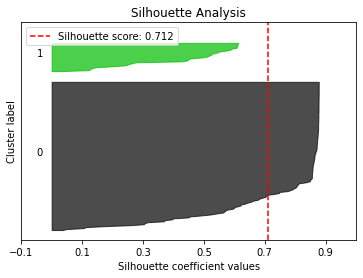

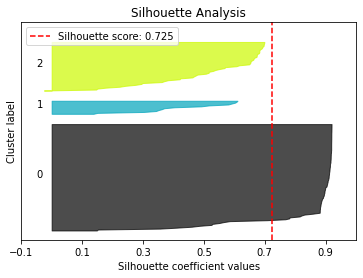

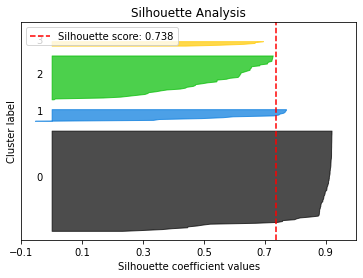

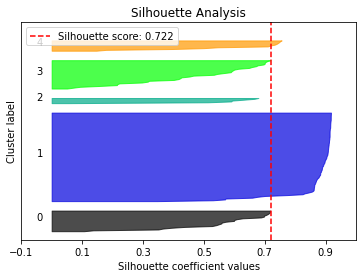

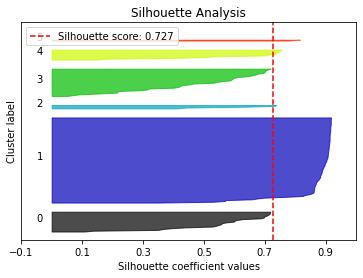

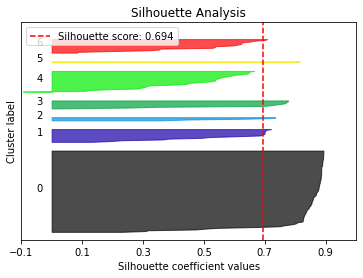

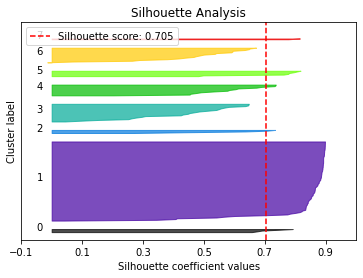

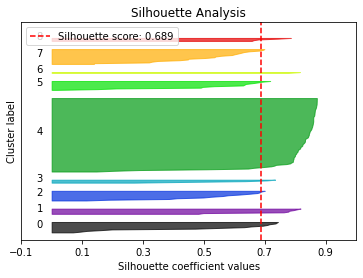

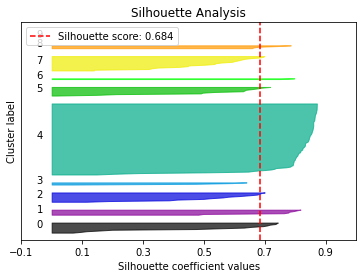

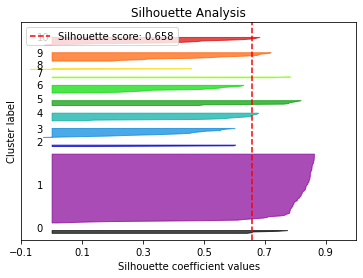

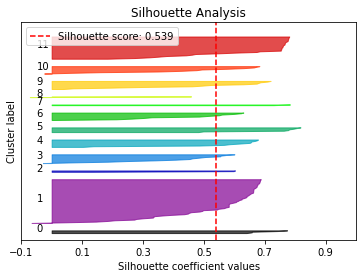

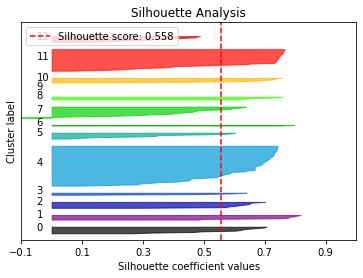

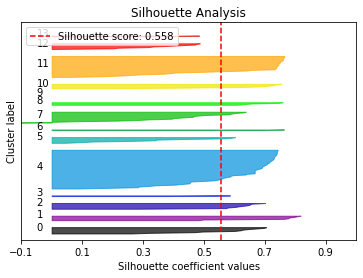

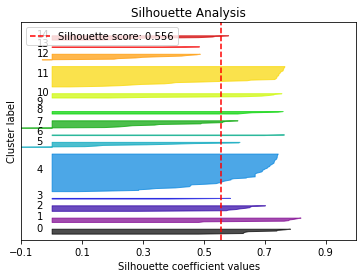

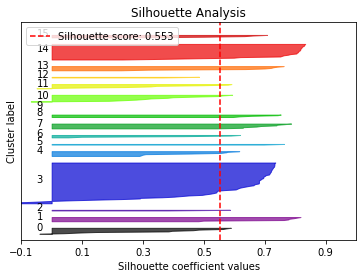

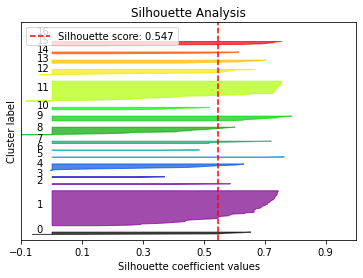

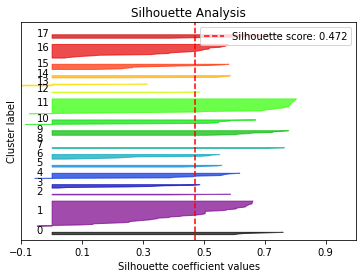

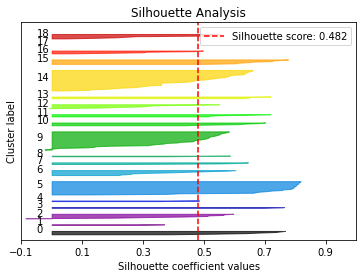

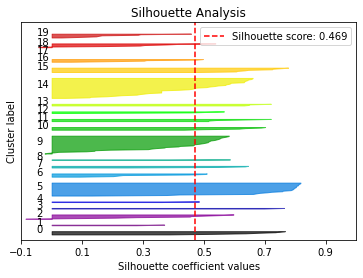

In [9]:
plot_multiple_silhouette(X[columns], 20, random_state=43, tol=1)
plt.show()

### Gráfico de agrupamiento con las clases halladas por KMeans

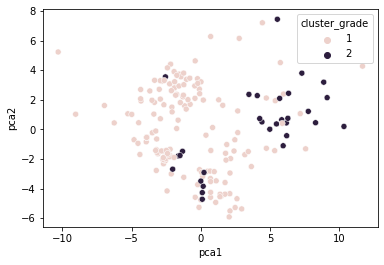

In [10]:
clf = KMeans(n_clusters=2, random_state=43, tol=1)
clf.fit(X=X[columns])
X['cluster_grade'] = clf.predict(X[columns]) + 1
sns.scatterplot(data=X, x='pca1', y='pca2', hue='cluster_grade')
plt.show()

Por último, se realizó Clustering utilizando el algoritmo KMeans para 2 clases para todos los documentos, como se identificó en el gráfico de Inercia por cantidad de clases. Dicha elección genero la dispersión vista en el gráfico anterior, en el cual se puede apreciar que el algoritmo pudo identificar el patrón necesario para separar el conjunto de datos que, en un principio, parecía no separable al ser visualizado mediante PCA. Si bien las clases no coinciden al 100%, ello es esperado ya que el algoritmo KMeans encuentra patrones usando los datos de entrenamiento. Dichos patrones no necesariamente serán los patrones originales, determinados por las clases originales del conjunto de datos (1 y 2 para primaria y secundaria). Sin embargo, sí se demuestra que sí existe un patrón que permite dividir el conjunto de datos en dos clases.

In [11]:
print_scores(X['grade'], X['cluster_grade'])

The accuracy score is: 0.5846994535519126
The precision score is: 0.5294117647058824
The recall score is: 0.9529411764705882
The F1 score is: 0.6806722689075629


# Clustering por categoría

En esta sección del reporte se realizará Clustering, usando el algoritmo KMeans, con los documentos de la base de datos, separados mediante categoría, siendo estos: Comunicación; Historia, Geografía y Economía, y Ciencia y Tecnología.

## Comunicación

### Dividiendo el dataset

 En esta subsección, se obtendrán las columnas numéricas necesarias para realizar la experimentación, obviando columnas categóricas como el nombre del archivo, la categoría y el ID.

In [12]:
X = texts[texts['category'] == 'Comunicación'].drop(columns=['filename', 'category', 'id']).dropna().copy()
X

,CNCADC,CNCAdd,CNCAll,CNCCaus,CNCLogic,CNCTemp,CRFANP1,CRFANPa,CRFAO1,CRFAOa,...,WRDNOUN,WRDPRO,WRDPRP1p,WRDPRP1s,WRDPRP2p,WRDPRP2s,WRDPRP3p,WRDPRP3s,WRDVERB,grade
46,1.814942,0.857973,61.114044,8.183738,47.254488,3.002904,0.069312,0.028033,0.323136,0.082070,...,318.241816,43.525607,0.659979,6.599789,1.253960,2.408923,0.560982,12.902587,113.252376,1.0
47,0.388232,0.258821,69.450436,4.874472,57.242688,6.686222,0.092777,0.034539,0.263065,0.056593,...,321.801398,49.132948,0.560780,2.372530,1.639203,4.615650,1.423518,10.999914,94.771806,1.0
48,1.212191,0.086585,64.130686,7.013392,45.803510,10.015008,0.063739,0.026429,0.209632,0.045644,...,304.202263,56.078273,1.673978,2.308936,0.375202,2.915031,2.366659,8.196721,138.334103,1.0
49,1.970964,0.096145,62.253629,7.980002,44.611095,7.595424,0.093656,0.046554,0.297281,0.071110,...,278.963561,55.138929,1.490241,3.941929,0.192289,2.884338,2.836266,11.633497,138.400154,1.0
50,1.026007,0.401481,61.605032,10.929206,43.092296,6.156042,0.077408,0.035984,0.288417,0.067927,...,298.166570,52.326359,2.052014,2.542713,0.133827,4.683945,1.739751,8.654146,118.080029,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,10.168675,1.012048,60.096386,15.084337,24.626506,9.204819,0.153777,0.113482,0.229317,0.130330,...,214.987952,88.867470,4.048193,12.144578,2.650602,15.180723,2.409639,20.192771,118.265060,2.0
179,8.489796,0.593692,56.653061,15.762523,25.751391,6.055659,0.072211,0.051115,0.170490,0.105130,...,233.202226,51.799629,4.779221,10.241187,0.044527,2.077922,1.128015,9.261596,108.897959,2.0
180,8.669041,0.941620,74.623352,19.456726,40.274707,5.281258,0.328918,0.254774,0.546726,0.382347,...,210.595267,62.586997,1.565954,20.848686,0.194465,0.020470,3.531073,13.745599,114.120200,2.0
181,4.147928,0.218312,82.958564,22.355150,52.045584,4.191591,0.287313,0.192939,0.375622,0.225790,...,301.619875,87.630441,1.309872,22.879099,0.480286,2.357770,2.969043,22.922761,102.606645,2.0


### PCA

Luego, para visualizar el conjunto de datos, se hara una reducción de dimensionalidad, a dos dimensiones, mediante el análisis de componentes principales (PCA), usando los datos numéricos pero estando estos estandarizados mediante la clase StandardScaler de Scikit learn.

In [13]:
X[['pca1', 'pca2']] = pca(StandardScaler().fit_transform(X[columns]), 2)
X

,CNCADC,CNCAdd,CNCAll,CNCCaus,CNCLogic,CNCTemp,CRFANP1,CRFANPa,CRFAO1,CRFAOa,...,WRDPRP1p,WRDPRP1s,WRDPRP2p,WRDPRP2s,WRDPRP3p,WRDPRP3s,WRDVERB,grade,pca1,pca2
46,1.814942,0.857973,61.114044,8.183738,47.254488,3.002904,0.069312,0.028033,0.323136,0.082070,...,0.659979,6.599789,1.253960,2.408923,0.560982,12.902587,113.252376,1.0,-0.776247,-1.667969
47,0.388232,0.258821,69.450436,4.874472,57.242688,6.686222,0.092777,0.034539,0.263065,0.056593,...,0.560780,2.372530,1.639203,4.615650,1.423518,10.999914,94.771806,1.0,0.438120,-4.090791
48,1.212191,0.086585,64.130686,7.013392,45.803510,10.015008,0.063739,0.026429,0.209632,0.045644,...,1.673978,2.308936,0.375202,2.915031,2.366659,8.196721,138.334103,1.0,0.842933,-4.051225
49,1.970964,0.096145,62.253629,7.980002,44.611095,7.595424,0.093656,0.046554,0.297281,0.071110,...,1.490241,3.941929,0.192289,2.884338,2.836266,11.633497,138.400154,1.0,-0.015879,-2.311642
50,1.026007,0.401481,61.605032,10.929206,43.092296,6.156042,0.077408,0.035984,0.288417,0.067927,...,2.052014,2.542713,0.133827,4.683945,1.739751,8.654146,118.080029,1.0,-0.486912,-2.562383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,10.168675,1.012048,60.096386,15.084337,24.626506,9.204819,0.153777,0.113482,0.229317,0.130330,...,4.048193,12.144578,2.650602,15.180723,2.409639,20.192771,118.265060,2.0,5.208665,0.344176
179,8.489796,0.593692,56.653061,15.762523,25.751391,6.055659,0.072211,0.051115,0.170490,0.105130,...,4.779221,10.241187,0.044527,2.077922,1.128015,9.261596,108.897959,2.0,3.532892,0.021990
180,8.669041,0.941620,74.623352,19.456726,40.274707,5.281258,0.328918,0.254774,0.546726,0.382347,...,1.565954,20.848686,0.194465,0.020470,3.531073,13.745599,114.120200,2.0,5.584555,7.883267
181,4.147928,0.218312,82.958564,22.355150,52.045584,4.191591,0.287313,0.192939,0.375622,0.225790,...,1.309872,22.879099,0.480286,2.357770,2.969043,22.922761,102.606645,2.0,5.029640,3.534909


### Gráfico de dispersion con las clases originales

En esta sección se visualizarán los datos usando los componentes principales hallados mediante PCA para visualizar el conjunto de datos, agrupados por el grado (1=Primaria, 2=Secundaria). Debido a la reducción de dimensionalidad, se pierde la información contenida en los demás atributos del conjunto de datos. Ello ocasiona que la visualización no necesariamente representa la distribución real del conjunto de datos. Sin embargo, se demostrará, mediante Clustering, que existe divisibilidad en el conjunto de datos.

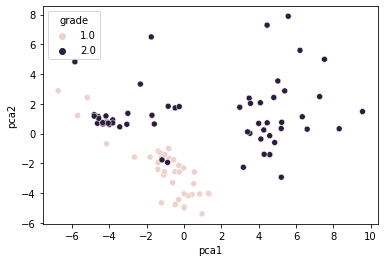

In [14]:
sns.scatterplot(data=X, x='pca1', y='pca2', hue='grade')
plt.show()

### Realizando clustering

#### Gráfico de Inercia por número de clases

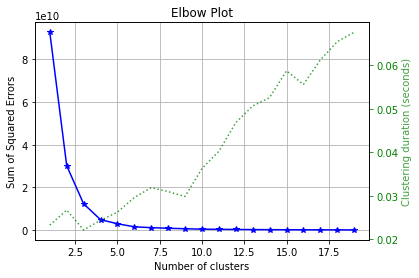

In [15]:
plot_elbow_curve(clf=KMeans(random_state=43, tol=1), X=X[columns], cluster_ranges=range(1, 20))
plt.show()

En el anterior gráfico se observa la cantidad de clusters, o clases, adecuados para el presente conjunto de datos. La coordenada donde se puede ver una curvatura de similar a un "codo" es la cual indica la cantidad adecuada de clases. En este caso, luego de aplicar el algoritmo de KMeans, este ha detectado que, con las 48 características obtenidas para los textos en español, la cantidad adecuada de clases es de 2, 3 o 4. Dicha elección se puede apreciar en los gráficos de silueta, en los cuales se puede observar que para la cantidad de 2, 3 o 4 clusters, las barras son las que poseen la mayor similitud entre ellas, además de estar lo más cerca o por delante de la linea punteada roja, que viene a ser el puntaje de silueta. Ello complementa la elección de clases del gráfico de codo. Sin embargo, debido a que se tienen originalment 2 clases, se eligirán 2 clases para el Clustering.

#### Gráfico de silueta

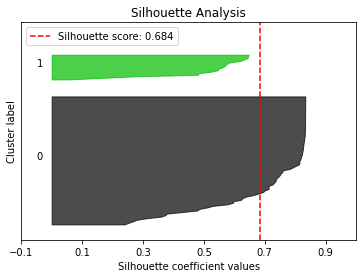

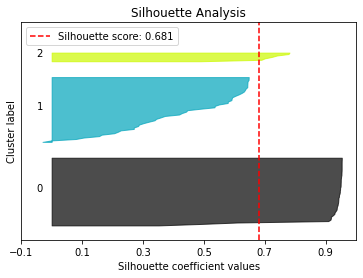

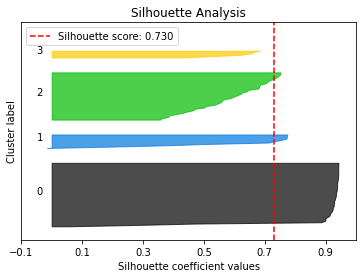

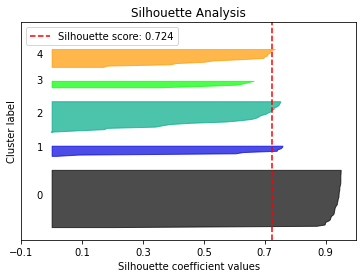

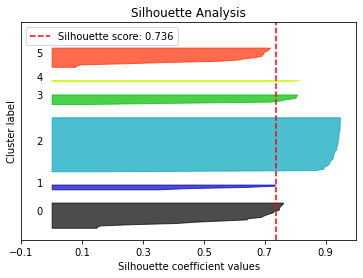

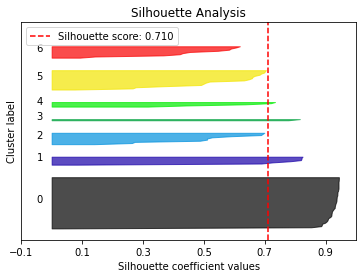

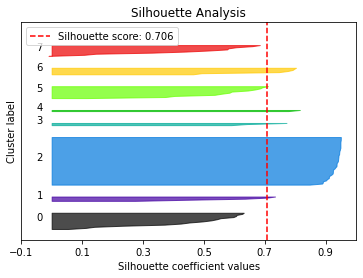

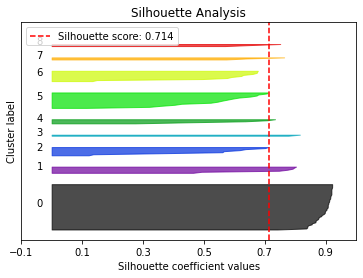

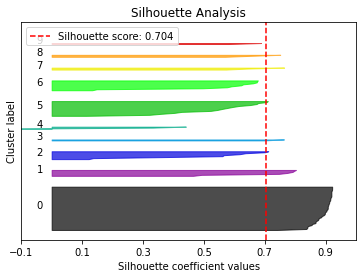

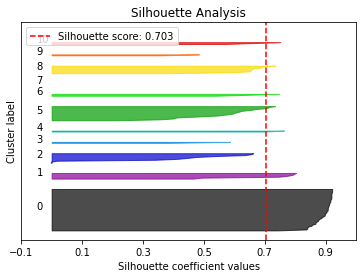

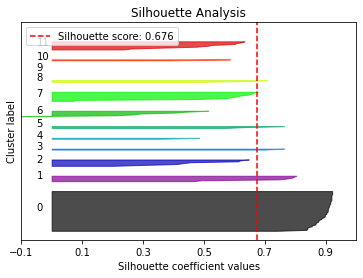

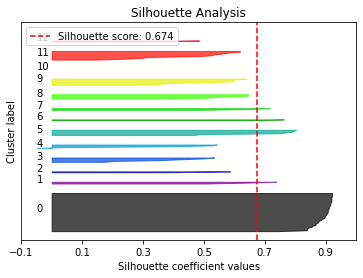

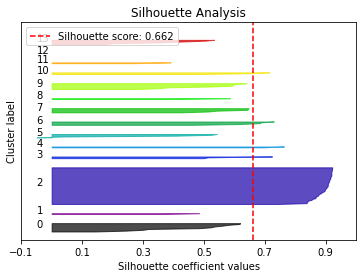

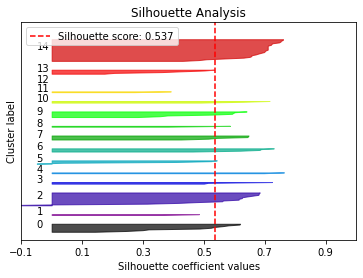

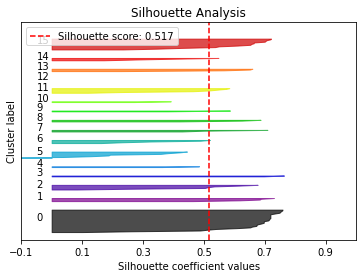

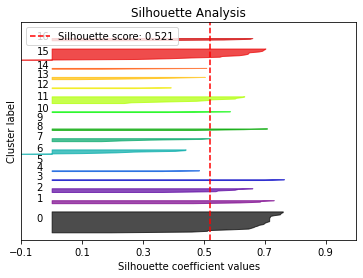

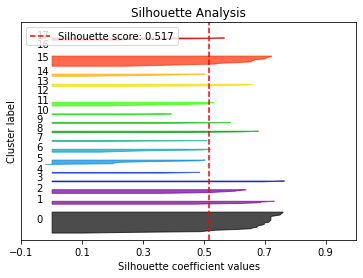

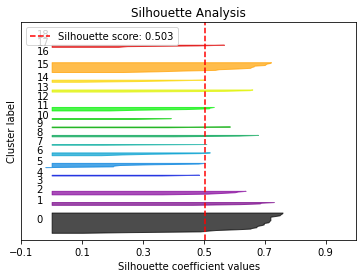

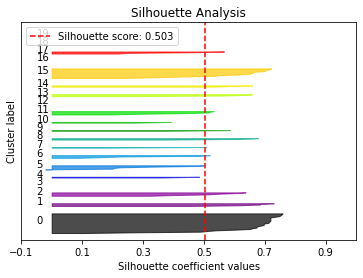

In [16]:
plot_multiple_silhouette(X[columns], 20, random_state=43, tol=1)
plt.show()

#### Gráfico de agrupamiento con las clases halladas por KMeans

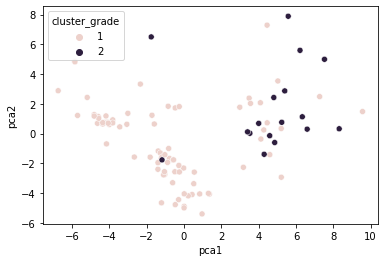

In [17]:
clf = KMeans(n_clusters=2, random_state=43, tol=1)
clf.fit(X[columns])
X['cluster_grade'] = clf.predict(X[columns]) + 1
sns.scatterplot(data=X, x='pca1', y='pca2', hue='cluster_grade')
plt.show()

Por último, se realizó Clustering utilizando el algoritmo KMeans para 2 clases para los documentos de Comunicación, como se identificó en el gráfico de Inercia por cantidad de clases. Dicha elección genero la dispersión vista en el gráfico anterior, en el cual se puede apreciar que el algoritmo pudo identificar el patrón necesario para separar el conjunto de datos que, en un principio, parecía no separable al ser visualizado mediante PCA. Si bien las clases no coinciden al 100%, ello es esperado ya que el algoritmo KMeans encuentra patrones usando los datos de entrenamiento. Dichos patrones no necesariamente serán los patrones originales, determinados por las clases originales del conjunto de datos (1 y 2 para primaria y secundaria). Sin embargo, sí se demuestra que sí existe un patrón que permite dividir el conjunto de datos en dos clases.

In [18]:
print_scores(X['grade'], X['cluster_grade'])

The accuracy score is: 0.5544554455445545
The precision score is: 0.4642857142857143
The recall score is: 1.0
The F1 score is: 0.6341463414634146


## Ciencia y Tecnología

### Dividiendo el dataset

 En esta subsección, se obtendrán las columnas numéricas necesarias para realizar la experimentación, obviando columnas categóricas como el nombre del archivo, la categoría y el ID.

In [19]:
X = texts[texts['category'] == 'CTA'].drop(columns=['filename', 'category', 'id']).dropna().copy()
X

,CNCADC,CNCAdd,CNCAll,CNCCaus,CNCLogic,CNCTemp,CRFANP1,CRFANPa,CRFAO1,CRFAOa,...,WRDNOUN,WRDPRO,WRDPRP1p,WRDPRP1s,WRDPRP2p,WRDPRP2s,WRDPRP3p,WRDPRP3s,WRDVERB,grade
34,1.909518,1.028202,56.110458,10.722679,39.512338,2.937720,0.138514,0.101761,0.422297,0.217308,...,324.618096,36.721504,0.146886,0.000000,0.000000,1.175088,1.909518,6.609871,103.701528,1.0
35,0.607349,0.303674,51.928333,7.591862,42.514425,0.911023,0.077670,0.083645,0.407767,0.303025,...,421.803826,30.671121,1.518372,0.607349,0.303674,0.607349,1.822047,6.680838,75.007592,1.0
36,2.619359,0.714371,61.674009,9.524943,45.362543,3.452792,0.104061,0.061967,0.530457,0.217439,...,343.969520,30.479819,2.738421,0.119062,0.000000,1.190618,1.666865,3.690916,95.963805,1.0
37,3.387438,1.693719,68.595625,8.892025,50.105857,4.516584,0.072414,0.056594,0.379310,0.189667,...,304.869442,35.003529,0.423430,0.000000,0.564573,1.976006,3.810868,6.633733,112.067749,1.0
38,5.303164,1.708797,61.693477,12.668670,38.123858,3.888987,0.114243,0.083596,0.400593,0.163723,...,252.371693,43.544871,3.417595,2.239114,0.058924,2.062342,2.298038,7.247658,112.073537,1.0
39,3.095633,1.105583,54.284135,8.126036,38.363737,3.593145,0.072614,0.039023,0.420124,0.205745,...,329.242676,30.624655,1.216142,0.331675,0.165837,0.221117,0.995025,3.980100,95.743505,1.0
40,0.414938,1.798064,62.517289,9.128631,49.377593,1.798064,0.067285,0.023975,0.403712,0.114860,...,317.704011,38.727524,4.149378,1.521438,0.138313,1.521438,0.829876,7.883817,118.948824,1.0
41,0.618582,1.237164,63.837684,10.515898,49.239144,2.226896,0.071730,0.025698,0.402954,0.111890,...,312.384016,38.846963,4.330075,1.113448,0.247433,1.237164,0.989732,7.546703,117.283187,1.0
42,0.971031,0.404596,59.880240,7.363651,46.690403,4.450558,0.092322,0.068735,0.374771,0.075031,...,272.536009,61.013109,5.502508,2.265739,0.161838,0.728273,1.699304,11.652371,143.631656,1.0
43,1.056444,0.150921,70.706308,7.093269,58.859040,3.546634,0.065443,0.039485,0.284916,0.053888,...,292.408693,53.576819,4.753999,1.358286,0.075460,0.679143,3.169333,11.696348,131.980078,1.0


### PCA

Luego, para visualizar el conjunto de datos, se hara una reducción de dimensionalidad, a dos dimensiones, mediante el análisis de componentes principales (PCA), usando los datos numéricos pero estando estos estandarizados mediante la clase StandardScaler de Scikit learn.

In [20]:
X[['pca1', 'pca2']] = pca(StandardScaler().fit_transform(X[columns]), 2)
X

,CNCADC,CNCAdd,CNCAll,CNCCaus,CNCLogic,CNCTemp,CRFANP1,CRFANPa,CRFAO1,CRFAOa,...,WRDPRP1p,WRDPRP1s,WRDPRP2p,WRDPRP2s,WRDPRP3p,WRDPRP3s,WRDVERB,grade,pca1,pca2
34,1.909518,1.028202,56.110458,10.722679,39.512338,2.937720,0.138514,0.101761,0.422297,0.217308,...,0.146886,0.000000,0.000000,1.175088,1.909518,6.609871,103.701528,1.0,0.692684,-1.770800
35,0.607349,0.303674,51.928333,7.591862,42.514425,0.911023,0.077670,0.083645,0.407767,0.303025,...,1.518372,0.607349,0.303674,0.607349,1.822047,6.680838,75.007592,1.0,1.582093,0.625274
36,2.619359,0.714371,61.674009,9.524943,45.362543,3.452792,0.104061,0.061967,0.530457,0.217439,...,2.738421,0.119062,0.000000,1.190618,1.666865,3.690916,95.963805,1.0,0.175864,-0.972942
37,3.387438,1.693719,68.595625,8.892025,50.105857,4.516584,0.072414,0.056594,0.379310,0.189667,...,0.423430,0.000000,0.564573,1.976006,3.810868,6.633733,112.067749,1.0,1.735130,-1.406752
38,5.303164,1.708797,61.693477,12.668670,38.123858,3.888987,0.114243,0.083596,0.400593,0.163723,...,3.417595,2.239114,0.058924,2.062342,2.298038,7.247658,112.073537,1.0,2.294147,-2.888684
39,3.095633,1.105583,54.284135,8.126036,38.363737,3.593145,0.072614,0.039023,0.420124,0.205745,...,1.216142,0.331675,0.165837,0.221117,0.995025,3.980100,95.743505,1.0,-0.326723,-1.302216
40,0.414938,1.798064,62.517289,9.128631,49.377593,1.798064,0.067285,0.023975,0.403712,0.114860,...,4.149378,1.521438,0.138313,1.521438,0.829876,7.883817,118.948824,1.0,-0.487343,0.644179
41,0.618582,1.237164,63.837684,10.515898,49.239144,2.226896,0.071730,0.025698,0.402954,0.111890,...,4.330075,1.113448,0.247433,1.237164,0.989732,7.546703,117.283187,1.0,-0.448359,0.251059
42,0.971031,0.404596,59.880240,7.363651,46.690403,4.450558,0.092322,0.068735,0.374771,0.075031,...,5.502508,2.265739,0.161838,0.728273,1.699304,11.652371,143.631656,1.0,0.665473,4.567576
43,1.056444,0.150921,70.706308,7.093269,58.859040,3.546634,0.065443,0.039485,0.284916,0.053888,...,4.753999,1.358286,0.075460,0.679143,3.169333,11.696348,131.980078,1.0,0.612620,4.920181


### Gráfico de dispersion con las clases originales

En esta sección se visualizarán los datos usando los componentes principales hallados mediante PCA para visualizar el conjunto de datos, agrupados por el grado (1=Primaria, 2=Secundaria). Debido a la reducción de dimensionalidad, se pierde la información contenida en los demás atributos del conjunto de datos. Ello ocasiona que la visualización no necesariamente representa la distribución real del conjunto de datos. Sin embargo, se demostrará, mediante Clustering, que existe divisibilidad en el conjunto de datos.

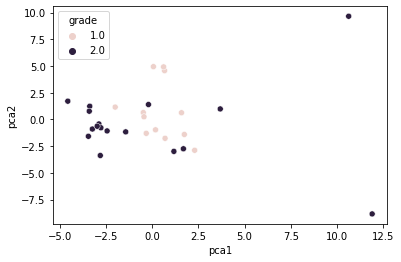

In [21]:
sns.scatterplot(data=X, x='pca1', y='pca2', hue='grade')
plt.show()

### Realizando clustering

#### Gráfico de Inercia por número de clases

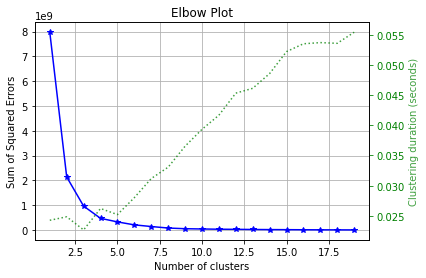

In [22]:
plot_elbow_curve(clf=KMeans(random_state=43, tol=1), X=X[columns], cluster_ranges=range(1, 20))
plt.show()

En el anterior gráfico se observa la cantidad de clusters, o clases, adecuados para el presente conjunto de datos. La coordenada donde se puede ver una curvatura de similar a un "codo" es la cual indica la cantidad adecuada de clases. En este caso, luego de aplicar el algoritmo de KMeans, este ha detectado que, con las 48 características obtenidas para los textos en español, la cantidad adecuada de clases es de 2, 3 o 4. Dicha elección se puede apreciar en los gráficos de silueta, en los cuales se puede observar que para la cantidad de 2, 3 y 4 clusters, las barras son las que poseen la mayor similitud entre ellas, además de estar lo más cerca o por delante de la linea punteada roja, que viene a ser el puntaje de silueta. Ello complementa la elección de clases del gráfico de codo. Sin embargo, como se tienen originalmente 2 clases, se usará ese valor para el Clustering.

#### Gráfico de silueta

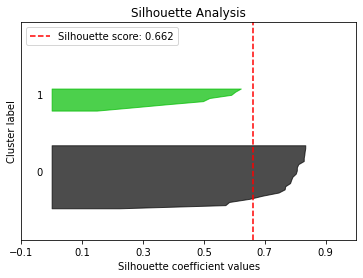

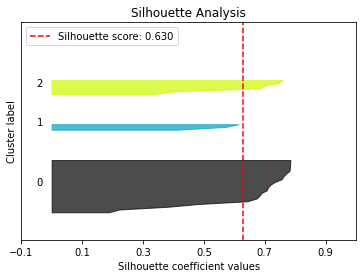

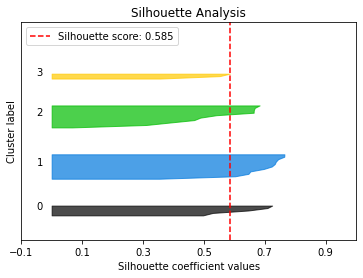

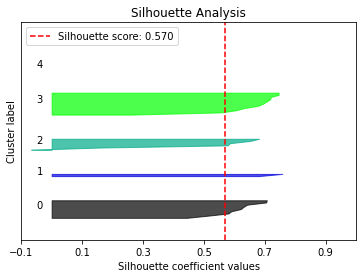

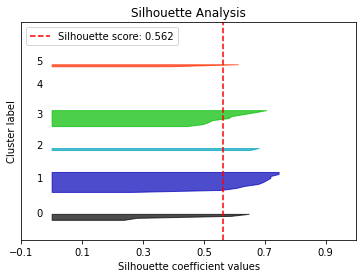

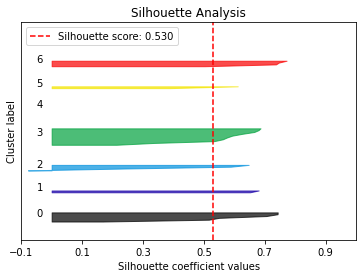

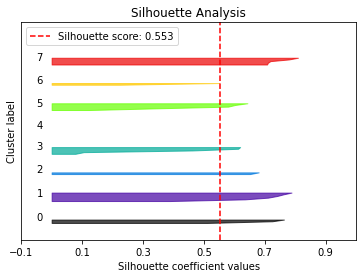

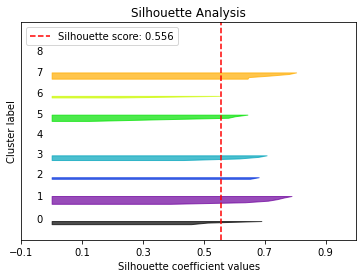

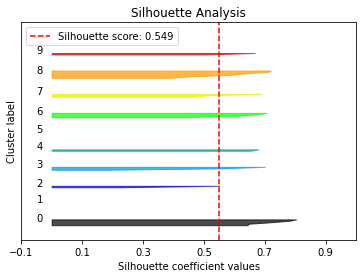

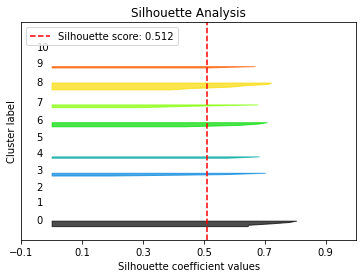

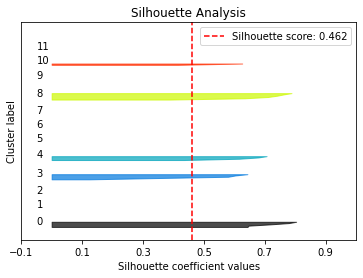

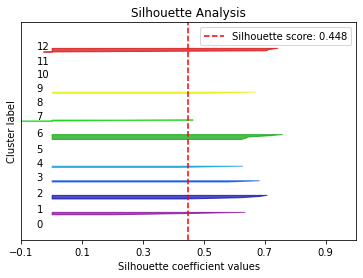

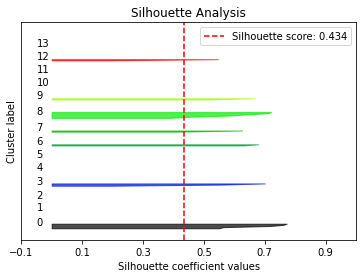

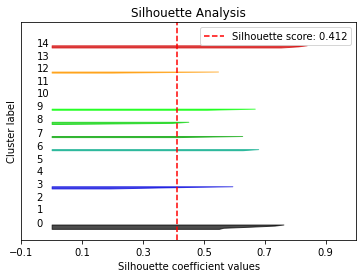

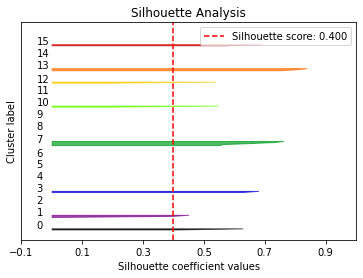

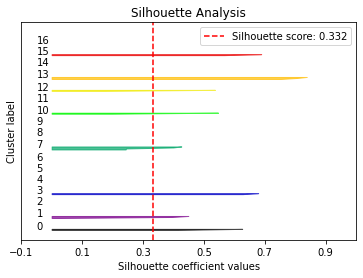

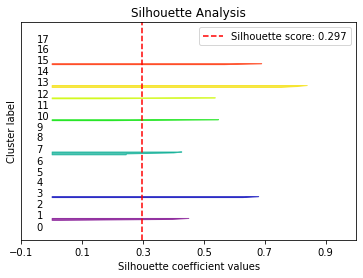

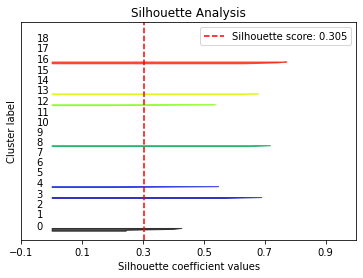

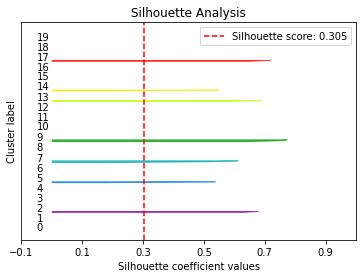

In [23]:
plot_multiple_silhouette(X[columns], 20, random_state=43, tol=1)
plt.show()

#### Gráfico de agrupamiento con las clases halladas por KMeans

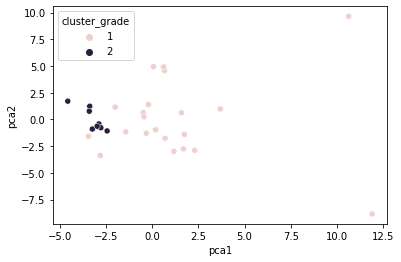

In [24]:
clf = KMeans(n_clusters=2, random_state=43, tol=1)
clf.fit(X[columns])
X['cluster_grade'] = clf.predict(X[columns]) + 1
sns.scatterplot(data=X, x='pca1', y='pca2', hue='cluster_grade')
plt.show()

Por último, se realizó Clustering utilizando el algoritmo KMeans para 2 clases para los documentos de Ciencia y Tecnología, como se identificó en el gráfico de Inercia por cantidad de clases. Dicha elección genero la dispersión vista en el gráfico anterior, en el cual se puede apreciar que el algoritmo pudo identificar el patrón necesario para separar el conjunto de datos que, en un principio, parecía no separable al ser visualizado mediante PCA. Si bien las clases no coinciden al 100%, ello es esperado ya que el algoritmo KMeans encuentra patrones usando los datos de entrenamiento. Dichos patrones no necesariamente serán los patrones originales, determinados por las clases originales del conjunto de datos (1 y 2 para primaria y secundaria). Sin embargo, sí se demuestra que sí existe un patrón que permite dividir el conjunto de datos en dos clases.

In [25]:
print_scores(X['grade'], X['cluster_grade'])

The accuracy score is: 0.6896551724137931
The precision score is: 0.5714285714285714
The recall score is: 1.0
The F1 score is: 0.7272727272727273


## Historia, Geografía y Economía

### Dividiendo el dataset

 En esta subsección, se obtendrán las columnas numéricas necesarias para realizar la experimentación, obviando columnas categóricas como el nombre del archivo, la categoría y el ID.

In [26]:
X = texts[texts['category'] == 'Historia, Geografía y Economía'].drop(columns=['filename', 'category', 'id']).dropna().copy()
X

,CNCADC,CNCAdd,CNCAll,CNCCaus,CNCLogic,CNCTemp,CRFANP1,CRFANPa,CRFAO1,CRFAOa,...,WRDNOUN,WRDPRO,WRDPRP1p,WRDPRP1s,WRDPRP2p,WRDPRP2s,WRDPRP3p,WRDPRP3s,WRDVERB,grade
0,5.595524,0.532907,56.754596,17.319478,30.109246,3.197442,0.099526,0.079630,0.236967,0.148887,...,338.395950,38.635758,0.000000,0.000000,0.000000,0.000000,2.398082,10.125233,110.578204,1.0
1,4.526167,0.848656,56.294201,13.861386,33.663366,3.394625,0.159722,0.119540,0.291667,0.197797,...,305.516266,38.189533,0.848656,0.565771,0.000000,0.848656,2.545969,8.769448,94.766620,1.0
2,1.737619,0.000000,59.079062,11.294526,40.834057,5.212858,0.026316,0.019822,0.197368,0.150034,...,278.019114,32.145960,0.000000,0.000000,0.000000,5.212858,1.737619,9.556907,149.435274,1.0
3,1.765225,1.765225,64.430715,12.356575,44.130627,4.413063,0.035714,0.039216,0.166667,0.142577,...,265.666372,52.956752,0.000000,0.000000,0.000000,9.708738,0.000000,9.708738,151.809356,1.0
4,5.965697,0.248571,52.945563,13.422819,30.325628,2.982849,0.151515,0.171011,0.430303,0.273384,...,325.130500,38.528461,0.000000,0.000000,0.000000,0.000000,1.739995,10.688541,93.711161,1.0
5,10.632642,0.000000,59.808612,13.556619,30.834662,4.784689,0.092784,0.065186,0.216495,0.134021,...,292.663477,40.404040,0.265816,1.594896,0.531632,1.329080,3.721425,10.101010,116.161616,1.0
6,5.033557,0.838926,59.563758,13.143177,37.192394,3.355705,0.098592,0.107259,0.274648,0.219344,...,299.217002,32.997763,0.000000,0.279642,0.000000,0.000000,1.677852,7.829978,92.002237,1.0
7,3.084833,1.542416,53.470437,13.624679,30.848329,4.370180,0.075581,0.121186,0.308140,0.210848,...,320.565553,46.529563,0.771208,0.000000,0.000000,0.000000,3.084833,7.712082,94.601542,1.0
8,1.895285,0.473821,48.329780,12.319356,31.272210,2.369107,0.090909,0.106170,0.296970,0.183936,...,329.305852,35.773513,0.000000,0.000000,0.000000,0.000000,2.132196,10.660981,79.838901,1.0
9,7.656316,0.425351,72.309655,16.588686,44.661846,2.977456,0.075269,0.039350,0.301075,0.200412,...,319.438537,31.050617,0.000000,3.828158,0.000000,0.000000,4.678860,6.805615,86.346236,1.0


### PCA

Luego, para visualizar el conjunto de datos, se hara una reducción de dimensionalidad, a dos dimensiones, mediante el análisis de componentes principales (PCA), usando los datos numéricos pero estando estos estandarizados mediante la clase StandardScaler de Scikit learn.

In [27]:
X[['pca1', 'pca2']] = pca(StandardScaler().fit_transform(X[columns]), 2)
X

,CNCADC,CNCAdd,CNCAll,CNCCaus,CNCLogic,CNCTemp,CRFANP1,CRFANPa,CRFAO1,CRFAOa,...,WRDPRP1p,WRDPRP1s,WRDPRP2p,WRDPRP2s,WRDPRP3p,WRDPRP3s,WRDVERB,grade,pca1,pca2
0,5.595524,0.532907,56.754596,17.319478,30.109246,3.197442,0.099526,0.079630,0.236967,0.148887,...,0.000000,0.000000,0.000000,0.000000,2.398082,10.125233,110.578204,1.0,0.257868,-1.440274
1,4.526167,0.848656,56.294201,13.861386,33.663366,3.394625,0.159722,0.119540,0.291667,0.197797,...,0.848656,0.565771,0.000000,0.848656,2.545969,8.769448,94.766620,1.0,0.306297,-2.200072
2,1.737619,0.000000,59.079062,11.294526,40.834057,5.212858,0.026316,0.019822,0.197368,0.150034,...,0.000000,0.000000,0.000000,5.212858,1.737619,9.556907,149.435274,1.0,-3.260789,-0.279127
3,1.765225,1.765225,64.430715,12.356575,44.130627,4.413063,0.035714,0.039216,0.166667,0.142577,...,0.000000,0.000000,0.000000,9.708738,0.000000,9.708738,151.809356,1.0,-5.321909,-1.335141
4,5.965697,0.248571,52.945563,13.422819,30.325628,2.982849,0.151515,0.171011,0.430303,0.273384,...,0.000000,0.000000,0.000000,0.000000,1.739995,10.688541,93.711161,1.0,1.727260,-0.847693
5,10.632642,0.000000,59.808612,13.556619,30.834662,4.784689,0.092784,0.065186,0.216495,0.134021,...,0.265816,1.594896,0.531632,1.329080,3.721425,10.101010,116.161616,1.0,-3.005582,-1.954841
6,5.033557,0.838926,59.563758,13.143177,37.192394,3.355705,0.098592,0.107259,0.274648,0.219344,...,0.000000,0.279642,0.000000,0.000000,1.677852,7.829978,92.002237,1.0,0.929610,-1.960499
7,3.084833,1.542416,53.470437,13.624679,30.848329,4.370180,0.075581,0.121186,0.308140,0.210848,...,0.771208,0.000000,0.000000,0.000000,3.084833,7.712082,94.601542,1.0,-0.427057,-0.473924
8,1.895285,0.473821,48.329780,12.319356,31.272210,2.369107,0.090909,0.106170,0.296970,0.183936,...,0.000000,0.000000,0.000000,0.000000,2.132196,10.660981,79.838901,1.0,0.457135,-1.167593
9,7.656316,0.425351,72.309655,16.588686,44.661846,2.977456,0.075269,0.039350,0.301075,0.200412,...,0.000000,3.828158,0.000000,0.000000,4.678860,6.805615,86.346236,1.0,0.306501,-1.458787


### Gráfico de dispersion con las clases originales

En esta sección se visualizarán los datos usando los componentes principales hallados mediante PCA para visualizar el conjunto de datos, agrupados por el grado (1=Primaria, 2=Secundaria). Debido a la reducción de dimensionalidad, se pierde la información contenida en los demás atributos del conjunto de datos. Ello ocasiona que la visualización no necesariamente representa la distribución real del conjunto de datos. Sin embargo, se demostrará, mediante Clustering, que existe divisibilidad en el conjunto de datos.

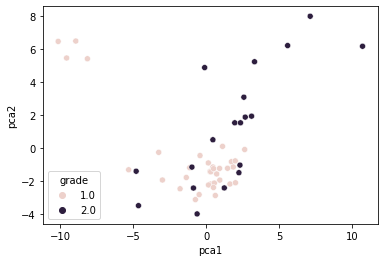

In [28]:
sns.scatterplot(data=X, x='pca1', y='pca2', hue='grade')
plt.show()

### Realizando clustering

#### Gráfico de Inercia por número de clases

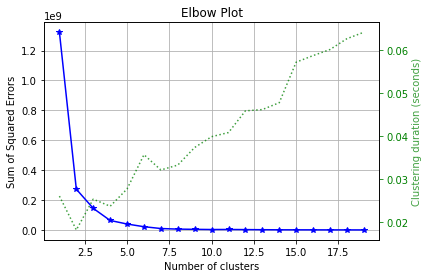

In [29]:
plot_elbow_curve(clf=KMeans(random_state=43, tol=1), X=X[columns], cluster_ranges=range(1, 20))
plt.show()

En el anterior gráfico se observa la cantidad de clusters, o clases, adecuados para el presente conjunto de datos. La coordenada donde se puede ver una curvatura de similar a un "codo" es la cual indica la cantidad adecuada de clases. En este caso, luego de aplicar el algoritmo de KMeans, este ha detectado que, con las 48 características obtenidas para los textos en español, la cantidad adecuada de clases es de 2, 3 o 4. Dicha elección se puede apreciar en los gráficos de silueta, en los cuales se puede observar que para la cantidad de 2, 3 y 4 clusters, las barras son las que poseen la mayor similitud entre ellas, además de estar lo más cerca o por delante de la linea punteada roja, que viene a ser el puntaje de silueta. Ello complementa la elección de clases del gráfico de codo.

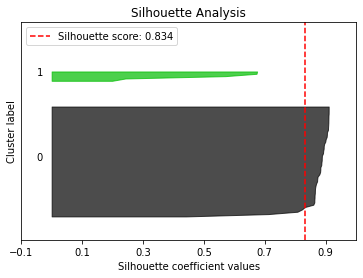

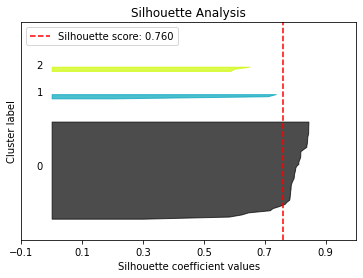

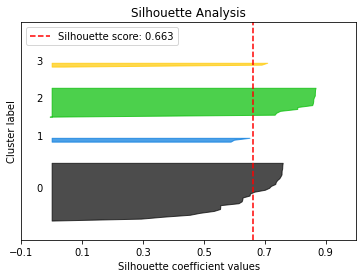

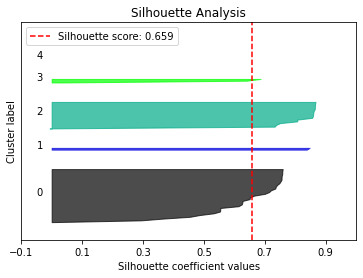

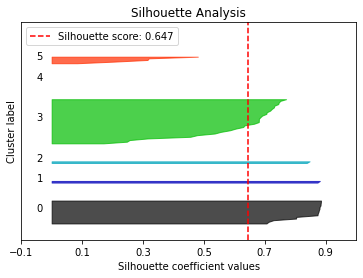

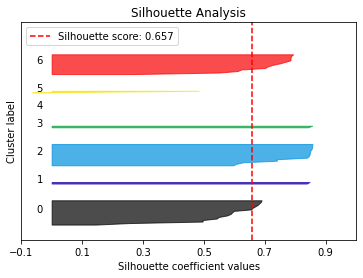

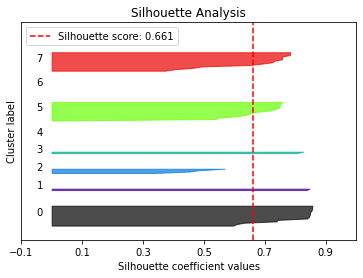

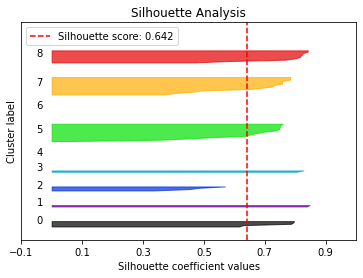

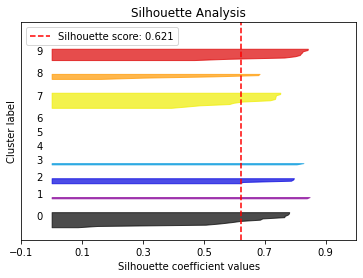

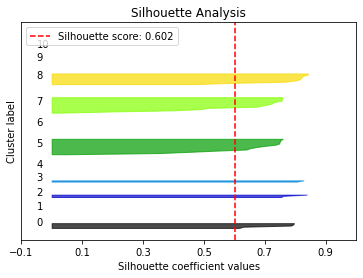

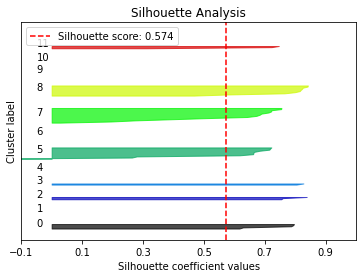

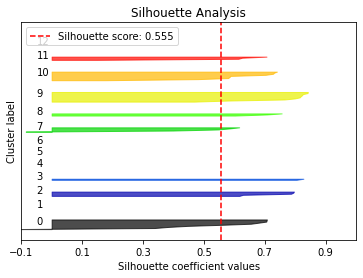

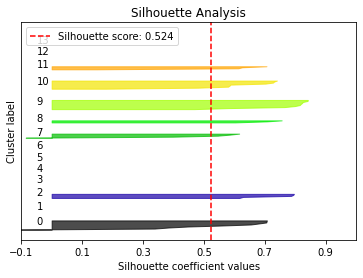

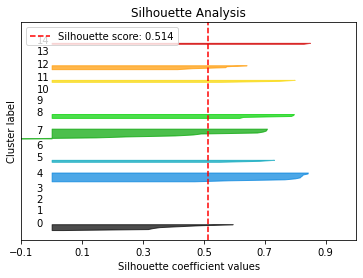

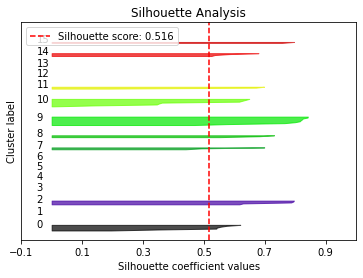

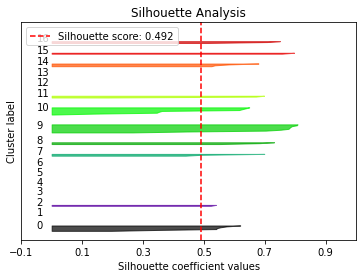

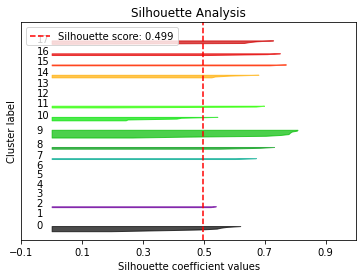

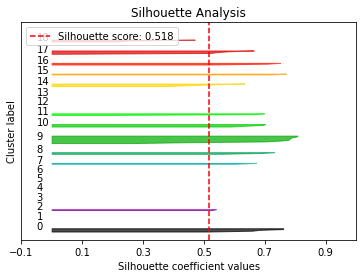

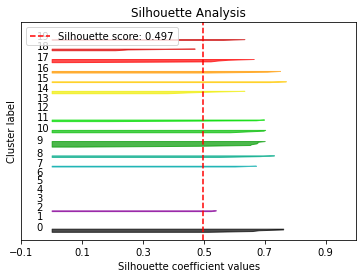

In [30]:
plot_multiple_silhouette(X[columns], 20, random_state=43, tol=1)
plt.show()

#### Gráfico de agrupamiento con las clases halladas por KMeans

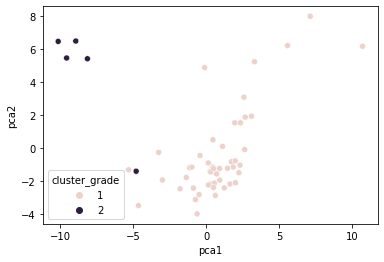

In [31]:
clf = KMeans(n_clusters=2, random_state=43, tol=1)
clf.fit(X[columns])
X['cluster_grade'] = clf.predict(X[columns]) + 1
sns.scatterplot(data=X, x='pca1', y='pca2', hue='cluster_grade')
plt.show()

Por último, se realizó Clustering utilizando el algoritmo KMeans para 2 clases para los documentos de Historia, Geografía y Tecnología, como se identificó en el gráfico de Inercia por cantidad de clases. Dicha elección genero la dispersión vista en el gráfico anterior, en el cual se puede apreciar que el algoritmo pudo identificar el patrón necesario para separar el conjunto de datos que, en un principio, parecía no separable al ser visualizado mediante PCA. Si bien las clases no coinciden al 100%, ello es esperado ya que el algoritmo KMeans encuentra patrones usando los datos de entrenamiento. Dichos patrones no necesariamente serán los patrones originales, determinados por las clases originales del conjunto de datos (1 y 2 para primaria y secundaria). Sin embargo, sí se demuestra que sí existe un patrón que permite dividir el conjunto de datos en dos clases.

In [32]:
print_scores(X['grade'], X['cluster_grade'])

The accuracy score is: 0.5849056603773585
The precision score is: 0.625
The recall score is: 0.8823529411764706
The F1 score is: 0.7317073170731708


# Conclusiones

Con las experimentaciones realizadas se observa que el conjunto de datos, ya sea con todos los textos o separados por categoría, son separables en las 48 dimensiones (Características) que posee, aunque el gráfico de dispersión en dos dimensiones no parezca divisible. Ello significa que será posible aplicar algoritmos de Machine Learning de aprendizaje supervisado (Clasificación) sobre el conjunto de datos, aunque la cantidad de clases identificadas por clustering no sea la misma que las que se poseen originalmente, debido a que los patrones reconocidos por KMeans no necesariamente son los originales.